# SpaCy Neural Models for Environmental NER

## 1. Introduction

### 1.1 Background and Purpose
This notebook continues the model training phase of the environmental Named Entity Recognition (NER) pipeline. Following the baseline evaluation using Conditional Random Fields (CRFs), this stage investigates the performance of two neural architectures provided by SpaCy: the convolutional neural network (CNN) pipeline and transformer-based models.

SpaCy’s `tok2vec` + CNN pipeline offers a lightweight, fast, and effective neural approach that learns contextual patterns using static word embeddings and convolutional layers. It is well suited for exploring how shallow neural models can generalise from rule-based annotations to unseen text.

In parallel, transformer-based models allow the use of pretrained contextual embeddings, such as those from BERT-style architectures. While more computationally demanding, they offer better long-range context modelling and generalisation potential.

Both model types are trained and evaluated on the same annotated dataset, which contains 735,542 sentences and over 1.2 million entity spans. These spans represent five domain-specific entity categories: TAXONOMY, HABITAT, ENV_PROCESS, POLLUTANT, and MEASUREMENT. The data was annotated using exact string matching against curated vocabularies, with custom merging and span logic, and follows the SpaCy `doc.ents` format.

This notebook assesses the ability of each neural model to learn from weak supervision and generalise to varied environmental texts, providing a solid basis for selecting the most effective approach.

### 1.2 Objectives
This notebook aims to train and compare multiple SpaCy NER models based on CNN and transformer architectures. The key objectives are to:

- Establish SpaCy CNN models as compact neural baselines that are faster than transformers but more expressive than CRFs.
- Evaluate transformer-based models using pretrained architectures to test generalisation on rare and unseen entities.
- Explore the effect of hyperparameters such as batch size, dropout, and training steps on both model types.
- Compare the outputs of each model on development and test texts using both quantitative and qualitative methods.
- Select the best-performing model and prepare it for final training and evaluation.

## 2. Preparing the Dataset for SpaCy Neural Models
The SpaCy neural models require training and evaluation data in its native binary format (`.spacy`), where each example contains raw text and associated entity spans stored in `doc.ents`. The dataset generated from the rule-based annotation pipeline was originally stored in `.jsonl` format, with each entry containing a sentence and a list of character-offset entity spans under the keys `"text"` and `"label"`.

To prepare this data for SpaCy’s training pipeline, the following steps are performed:

1. Load the annotated `.jsonl` file into memory.
2. Split the dataset into training, validation, and test sets using a 70/15/15 ratio.
3. Convert each list of records into `DocBin` objects using `nlp.make_doc(...)` and character-span alignment.
4. Save the converted data to `.spacy` files, which are required for use with SpaCy’s CLI training interface.

Unlike the CRF model, there is no need to convert to BIO tags explicitly, as SpaCy internally handles alignment between raw text and annotated entity spans during training. This makes the pipeline more streamlined while maintaining compatibility with upcoming neural models.

This step ensures the data is formatted efficiently for high-throughput model training and consistent evaluation.

In [1]:
from pathlib import Path
import os
import json
import random
from random import sample
from collections import Counter

import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch
from spacy.scorer import Scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import trange

TRAINING_DATA_PATH = Path("../data/json/training_data.jsonl")
SPACY_MODEL_PATH = Path("../models/spaCy")
SPACY_DATA_PATH = Path("../data/spaCy")
CONFIG_PATH = Path("./spaCy_configs/cnn")
CONFIG_PATH_TRANSFORMER = Path("./spaCy_configs/transformer")

SPACY_MODEL_PATH.mkdir(parents=True, exist_ok=True)
SPACY_DATA_PATH.mkdir(parents=True, exist_ok=True)

### 2.1 Load and Inspect Annotated Data
The annotated dataset is stored in `.jsonl` format, with each line containing a sentence `text` and a list of entity spans under the key `label`. Each span is defined using character offsets and a corresponding entity label, reflecting the results of the earlier rule-based annotation stage.


In [34]:
def load_jsonl(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

In [35]:
training_data = load_jsonl(TRAINING_DATA_PATH)

len(training_data)

735479

In [4]:
for ex in sample(training_data, 3):
    text = ex["text"]
    entities = ex["label"]
    print("\nText:", text)
    for start, end, label in entities:
        print(f" → {text[start:end]} [{label}]")


Text: Biodiverse, multitrophic communities are increasingly recognised as important promoters of species persistence and resilience under environmental change.
 → environmental change [ENV_PROCESS]

Text: Environmental groups have long campaigned to protect the area, which sustains millions of migrating birds and is home to a major population of endangered Iberian lynxes, pointing out that the illegal wells sunk to feed the region’s numerous soft fruit farms are stressing the aquifer.
 → birds [TAXONOMY]
 → Iberian lynxes [TAXONOMY]

Text: world is not on track to prevent catastrophic warming, to keep temperatures from increasing more than 2C (3.6F), Patricia Espinosa, the executive secretary of the United Nations framework convention on climate change, said earlier this month.
 → temperatures [MEASUREMENT]
 → climate change [ENV_PROCESS]


A random sample of entries confirms that the spans have been accurately mapped to their corresponding substrings in the text. Entities such as *environmental change* and *climate change* are correctly identified as `ENV_PROCESS`, while biological mentions like *birds* and *Iberian lynxes* are classified as `TAXONOMY`. Quantitative references such as *temperatures* are assigned the `MEASUREMENT` label.

This inspection demonstrates both the structural integrity of the span annotations and the diversity of entity types captured by the rule-based method. The presence of both single-token and multi-token entities, along with varying sentence structures, supports the suitability of the data for training a generalisable NER model.

### 2.2 Train–Validation–Test Split
Before converting the data into SpaCy’s training format, the dataset must be partitioned into separate subsets for training, validation, and testing. This allows for fair evaluation of the model’s ability to generalise beyond its training data.

The dataset is randomly split into 70% for training, 15% for validation, and 15% for testing. The validation set is used during model training to monitor performance and prevent overfitting, while the test set is held out entirely for final evaluation.

Unlike standard classification tasks, stratified splitting is not used here because the entity labels exist as spans within text rather than as discrete document-level categories. The large size of the dataset ensures sufficient representation of each entity type across all three subsets.

In [36]:
# First split: 70% train, 30% temp
train_data, temp_data = train_test_split(training_data, test_size=0.3, random_state=42)

# Second split: 15% val, 15% test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 514835
Validation size: 110322
Test size: 110322


The split results in 514,835 training examples and 110,322 each for validation and test. These proportions provide a strong foundation for both model optimisation and evaluation. Entity span diversity is preserved across subsets due to the randomised sampling, making the split suitable for training a general-purpose neural NER model.

### 2.3 Convert Records to SpaCy DocBin Format

SpaCy's training pipeline requires data to be serialised into its binary `.spacy` format, which is optimised for speed and memory efficiency. To achieve this, each sentence and its associated entity spans are converted into a `Doc` object and then stored in a `DocBin` container.

The `char_span` method is used to align each entity span (stored as character offsets) with the correct token boundaries within the `Doc`. This is necessary because entity spans must match valid token boundaries for SpaCy to process them correctly. In cases where the span cannot be aligned (due to tokenisation mismatch or annotation error), the resulting `None` values are filtered out before assigning to `doc.ents`.

This process ensures that only well-formed entity spans are used in training, maintaining data integrity and preventing runtime errors during model fitting.


In [37]:
def convert_json_records_to_docbin(records, nlp):
    doc_bin = DocBin()
    for record in records:
        text = record["text"]
        entities = record["label"]
        doc = nlp.make_doc(text)
        spans = [doc.char_span(start, end, label=label) for start, end, label in entities]
        spans = [span for span in spans if span is not None]
        doc.ents = spans
        doc_bin.add(doc)
    return doc_bin

In [38]:
nlp_blank = spacy.blank("en")

train_docbin = convert_json_records_to_docbin(train_data, nlp_blank)
val_docbin = convert_json_records_to_docbin(val_data, nlp_blank)
test_docbin = convert_json_records_to_docbin(test_data, nlp_blank)

print(f"Train: {len(list(train_docbin.get_docs(nlp_blank.vocab)))}")
print(f"Val: {len(list(val_docbin.get_docs(nlp_blank.vocab)))}")
print(f"Test: {len(list(test_docbin.get_docs(nlp_blank.vocab)))}")

Train: 514835
Val: 110322
Test: 110322


The output confirms that each subset has been successfully converted into a `DocBin` object, with valid entity spans attached to each `Doc`. The number of `Doc` objects in each bin matches the counts from the previous data split, confirming that no data was lost during conversion.

By filtering out `None` spans, the function ensures that only valid, token-aligned entity annotations are retained, which is essential for error-free training using SpaCy’s NER component.


### 2.4 Prepare `Example` Objects for Evaluation and Fine-Grained Control
While SpaCy's CLI training interface operates directly on `.spacy` files, evaluation and diagnostics often require the use of `Example` objects. These allow more granular inspection of model predictions and facilitate custom scoring, visualisation, and error analysis.

Each `Example` pairs a `Doc` object with its annotated entity spans, allowing functions like `evaluate_ner_model()` to compare predictions against the ground truth at a span level.

This step converts the `DocBin` datasets into in-memory `Example` lists for the training, validation, and test sets. Although not strictly necessary for model training via the CLI, these objects provide flexibility for analysis and are essential for consistent evaluation across all models.

In [39]:
def prepare_examples_from_docbin(docbin, vocab):
    docs = list(docbin.get_docs(vocab))
    examples = [
        Example.from_dict(doc, {
            "entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        }) for doc in docs
    ]
    return examples

In [40]:
train_examples = prepare_examples_from_docbin(train_docbin, nlp_blank.vocab)
val_examples = prepare_examples_from_docbin(val_docbin, nlp_blank.vocab)
test_examples = prepare_examples_from_docbin(test_docbin, nlp_blank.vocab)

In [10]:
sample_example = random.choice(train_examples)
print("Text:", sample_example.reference.text)
for ent in sample_example.reference.ents:
    print(f" → {ent.text} [{ent.label_}]")

Text: Inland waters are unique ecosystems offering services and habitat resources upon which many species depend.
 → Inland waters [HABITAT]
 → ecosystems [HABITAT]
 → habitat [HABITAT]


The sample output confirms that entity spans from the original annotations have been correctly mapped to their corresponding substrings in the `Doc` objects. Terms such as *Inland waters*, *ecosystems*, and *habitat* are properly recognised as `HABITAT`, demonstrating that the conversion to `Example` objects retains both the structure and semantics needed for reliable evaluation.

### 2.5 Save Dataset in `.spacy` Format
To enable efficient training using SpaCy’s CLI interface, the processed datasets must be saved in SpaCy’s binary `.spacy` format. This format stores tokenised `Doc` objects and their associated entity spans in a compact, serialised form optimised for fast loading during training.

The `save_examples_to_spacy_file` function writes each list of `Example` objects to a file by serialising the underlying `Doc` objects (i.e., `example.reference`). These files are then referenced by the training configuration to load the data in a format that is fully compatible with SpaCy's pipeline.


In [41]:


def save_examples_to_spacy_file(examples, nlp, output_path):
    doc_bin = DocBin()
    for example in examples:
        doc_bin.add(example.reference)
    doc_bin.to_disk(output_path)

In [42]:
save_examples_to_spacy_file(train_examples, nlp_blank, SPACY_DATA_PATH / "train.spacy")
save_examples_to_spacy_file(val_examples, nlp_blank, SPACY_DATA_PATH / "val.spacy")
save_examples_to_spacy_file(test_examples, nlp_blank, SPACY_DATA_PATH / "test.spacy")

## 3. Training SpaCy CNN Models
This section introduces the training of neural models using SpaCy’s built-in convolutional neural network (CNN) pipeline for NER. Unlike classical models such as CRFs, SpaCy models operate directly on raw text and learn features automatically through a `tok2vec` embedding layer followed by convolutional filters that encode local context.

The `tok2vec` component maps each token into a dense vector representation by combining word embeddings (e.g. hash-based, static, or pretrained) with contextual information from neighbouring tokens. This forms the input to the CNN encoder, which applies multiple convolutional filters across sliding windows of tokens.

For instance, given the phrase *"30 kg of nitrogen"*, a convolutional window might span tokens like *"30"*, *"kg"*, and *"of"*. A filter trained to detect measurements would recognise this pattern and help classify the span as a `MEASUREMENT` entity.

These filters function similarly to edge detectors in image processing: they scan over the input and activate when local patterns are detected (e.g. a numeric unit or organism mention). By stacking multiple filters and layers, the model captures increasingly complex structures such as noun phrases or taxonomic clusters.

Training is conducted using SpaCy’s CLI interface, which relies on a configuration file to define all components of the pipeline, including architecture, hyperparameters, and data paths. Each model is trained with different settings to explore the impact of batch size, dropout, encoder depth, and training duration.

The following sections describe each configuration, along with its rationale and the resulting model performance.


### 3.1 Training the Baseline Model
The first model in this notebook serves as a neural baseline for comparison against future CNN and transformer models. It uses a standard SpaCy CNN pipeline generated via the `init config` command. The configuration is optimised for accuracy and does not include any pre-trained embeddings or vectors.

In [13]:
!python -m spacy init config ./spaCy_configs/cnn/config0.cfg --lang en --pipeline ner --optimize accuracy

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/cnn/config0.cfg
You can now add your data and train your pipeline:
python -m spacy train config0.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


After generating the default `config0.cfg`, key parameters were manually adjusted to define a lightweight yet expressive model suitable for the size and structure of the training dataset. This model uses SpaCy's `tok2vec` and `ner` components without any pre-initialised weights. The aim is to assess how well the model can learn purely from the rule-based annotations.

The table below summarises the main configuration choices:

| Parameter                     | Value       | Purpose                                                                 |
|------------------------------|-------------|-------------------------------------------------------------------------|
| `vectors`                    | `null`      | No pre-trained vectors; model learns embeddings from scratch.          |
| `init_tok2vec`               | `null`      | No initial weights; embeddings are trained directly.                   |
| `batch_size`                 | `1000`      | Word-based batch size; tuned for speed and stability.                  |
| `encoder architecture`       | `MaxoutWindowEncoder.v2` | Standard CNN encoder in SpaCy.                 |
| `encoder width`              | `128`       | Moderate channel size; balances capacity and speed.                    |
| `encoder depth`              | `4`         | Four convolutional layers; enough to capture local patterns.           |
| `dropout`                    | `0.5`       | Regularisation to reduce overfitting.                                  |
| `max_steps`                  | `2000`      | Maximum training steps.                                                |
| `patience`                   | `1000`      | Early stopping if validation score does not improve.                   |
| `learn_rate`                 | `0.001`     | Default learning rate for Adam optimiser.                              |
| `eval_frequency`             | `500`       | Evaluate every 500 steps on the validation set.                        |



With the configuration file prepared and the dataset saved in SpaCy’s `.spacy` format, the model is trained using SpaCy’s command-line interface. The training command specifies the configuration file, input and output directories, and GPU usage. This setup allows reproducible training without managing components manually in code.

During training, progress is printed after each evaluation interval. The reported metrics include:

- `LOSS TOK2VEC`: Loss from the token-to-vector embedding layer. This shows how well the model is learning word-level representations.
- `LOSS NER`: Loss from the named entity recognition component. This reflects how accurately the model predicts entity spans.
- `ENTS_P`: Precision, or the percentage of predicted entities that are correct.
- `ENTS_R`: Recall, or the percentage of actual entities that the model successfully identifies.
- `ENTS_F`: F1-score, which balances precision and recall in a single value.
- `SCORE`: The overall performance score used to decide whether training is improving.

These metrics are calculated on the validation set. They are used to monitor learning and trigger early stopping if the model stops improving.

When training ends, the best-performing model is saved in the `model-best` directory within the output folder. This version includes


In [15]:
!python -m spacy train {CONFIG_PATH / "config0.cfg"} \
  --output {SPACY_MODEL_PATH / "cnn_0"} \
  --paths.train {SPACY_DATA_PATH / "train.spacy"} \
  --paths.dev {SPACY_DATA_PATH / "val.spacy"} \
  --gpu-id 0 --verbose

[2025-06-30 21:41:31,308] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
✔ Created output directory: ../models/spaCy/cnn_0
ℹ Saving to output directory: ../models/spaCy/cnn_0
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-06-30 21:41:31,657] [INFO] Set up nlp object from config
[2025-06-30 21:41:31,666] [DEBUG] Loading corpus from path: ../data/spaCy/val.spacy
[2025-06-30 21:41:31,668] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-06-30 21:41:31,668] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-06-30 21:41:31,671] [INFO] Created vocabulary
[2025-06-30 21:41:31,671] [INFO] Finished initializing nlp object
[2025-06-30 21:45:54,488] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If 

### Model Statistics

| Model   | Dropout | Batch Size | Max Steps | Learn Rate | Loss TOK2VEC | Loss NER | F1   |
|---------|---------|------------|-----------|------------|---------------|----------|------|
| cnn_0   | 0.5     | 1000       | 2000      | 0.001      | 2275.93       | 8088.55  | 0.86 |

The baseline CNN model was trained using a batch size of 1000 and a dropout rate of 0.5. No pretrained word vectors or initial weights were used. The model learned all embeddings and parameters from scratch using a fixed learning rate of 0.001 over 2000 update steps.

Training began with minimal signal (`F1 = 0.07` at step 0), indicating no prior knowledge of the data. Over time, the validation metrics improved steadily. By step 2000, the model achieved an F1-score of 86.03%, with precision at 89.68% and recall at 82.66%. This performance suggests the model was able to generalise well from rule-based annotations to diverse sentence structures.

`LOSS TOK2VEC` reflects how well the model learned internal token embeddings. This value started low and increased as the model built more meaningful feature representations. A rise in `tok2vec` loss is expected when embeddings shift to encode more complex contextual patterns, especially in multi-entity sentences.

`LOSS NER` measures the model's ability to classify entity spans correctly. This value increased over time as the model encountered more difficult examples and adjusted its decision boundaries. Importantly, this rise in raw loss was accompanied by improved accuracy, showing that the model continued to learn even as the training examples became harder to predict.

This model establishes a strong baseline. It shows that SpaCy's CNN pipeline, even without pretrained features, can learn useful representations from environmental data with structured but weak supervision. It provides a useful reference point for evaluating future improvements using alternative configurations or model architectures.

### 3.2 SpaCy Model 2: Lower Capacity, Longer Training
The second model, `cnn_1`, is designed to test a smaller NER classification head over a longer training schedule. It keeps the same CNN encoder from the baseline (`MaxoutWindowEncoder.v2` with width 128 and depth 4), but reduces the size of the NER head by setting `hidden_width` to 32 and `maxout_pieces` to 2. This lowers the number of parameters in the classification layer, helping evaluate whether a lightweight model can still generalise well.

The `dropout` remains at 0.5 to prevent overfitting, but the number of training steps is increased to 20,000. Early stopping with a patience of 1000 steps is enabled to stop training if validation performance stops improving. The learning rate remains unchanged at 0.001.

To support more frequent updates, the batch size is reduced to 500. Smaller batches introduce more noise during training, which can improve generalisation in lower-capacity models.

| Parameter                     | Value       |
|------------------------------|-------------|
| `vectors`                    | `null`      |
| `init_tok2vec`               | `null`      |
| `batch_size`                 | `500`       |
| `encoder architecture`       | `MaxoutWindowEncoder.v2` |
| `encoder width`              | `128`       |
| `encoder depth`              | `4`         |
| `dropout`                    | `0.5`       |
| `max_steps`                  | `20000`     |
| `patience`                   | `1000`      |
| `learn_rate`                 | `0.001`     |
| `eval_frequency`             | `200`       |


In [17]:
!python -m spacy init config ./spaCy_configs/cnn/config1.cfg --lang en --pipeline ner --optimize accuracy

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/cnn/config1.cfg
You can now add your data and train your pipeline:
python -m spacy train config1.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [18]:
!python -m spacy train {CONFIG_PATH / "config1.cfg"} \
  --output {SPACY_MODEL_PATH / "cnn_1"} \
  --paths.train {SPACY_DATA_PATH / "train.spacy"} \
  --paths.dev {SPACY_DATA_PATH / "val.spacy"} \
  --gpu-id 0  --verbose

[2025-06-30 22:40:35,084] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: ../models/spaCy/cnn_1
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-06-30 22:40:35,418] [INFO] Set up nlp object from config
[2025-06-30 22:40:35,428] [DEBUG] Loading corpus from path: ../data/spaCy/val.spacy
[2025-06-30 22:40:35,429] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-06-30 22:40:35,429] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-06-30 22:40:35,432] [INFO] Created vocabulary
[2025-06-30 22:40:35,432] [INFO] Finished initializing nlp object
[2025-06-30 22:44:44,003] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-l

### Model Statistics

| Model   | Dropout | Batch Size | Max Steps | Learn Rate | Loss TOK2VEC | Loss NER | F1   |
|---------|---------|------------|-----------|------------|---------------|----------|------|
| cnn_0   | 0.5     | 1000       | 2000      | 0.001      | 2275.93       | 8088.55  | 0.86 |
| cnn_1   | 0.5     | 500        | 20000     | 0.001      | 437.11        | 1739.76  | 0.96 |

The second CNN model (`cnn_1`) was trained using the same encoder architecture as the baseline but with a longer training schedule and smaller batch size. The aim was to give the model more update opportunities and allow it to converge more gradually.

Training continued up to step 12000, where early stopping was triggered. By this point, the model had reached a validation F1-score of 95.77%, with precision at 96.19% and recall at 95.35%. This is a clear improvement over the baseline model, which plateaued at 86.03% F1.

`LOSS NER` dropped from over 8000 to 1739.76, indicating that the model became much more confident and accurate in its span predictions. `LOSS TOK2VEC` also reduced significantly to 437.11, suggesting that the token embeddings learned more stable and informative representations over time.

The smaller batch size (500 vs 1000) allowed for more frequent parameter updates. This helped the model adapt quickly during training, while the longer training horizon gave it time to refine internal representations. The high dropout rate (0.5) helped prevent overfitting even as model performance increased.

This result shows that careful tuning of batch size and training schedule can significantly improve model quality, even without changing the encoder architecture or introducing external features.

### 3.3 SpaCy Model 3: Shallower Encoder with Lower Dropout
The third model (`cnn_2`) tests how well a simpler encoder performs when trained over a longer schedule. The number of convolutional layers in the `tok2vec` encoder is reduced from 4 to 2. This change makes the model faster to train and may encourage it to focus on simpler features.

The dropout rate is also lowered from 0.5 to 0.3. Since the encoder is smaller, applying strong regularisation could lead to underfitting. A moderate dropout allows the model to retain more training signal while still reducing the risk of overfitting.

All other settings are the same as in the previous model: 20,000 maximum steps, early stopping patience of 1000 steps, a batch size of 500, and a learning rate of 0.001.

This configuration helps evaluate whether a shallower network with lighter regularisation can match the performance of deeper models trained under similar conditions.

| Parameter                     | Value       |
|------------------------------|-------------|
| `vectors`                    | `null`      |
| `init_tok2vec`               | `null`      |
| `batch_size`                 | `500`       |
| `encoder architecture`       | `MaxoutWindowEncoder.v2` |
| `encoder width`              | `128`       |
| `encoder depth`              | `2`         |
| `dropout`                    | `0.3`       |
| `max_steps`                  | `20000`     |
| `patience`                   | `1000`      |
| `learn_rate` (Adam)          | `0.001`     |
| `eval_frequency`             | `200`       |

In [2]:
!python -m spacy init config ./spaCy_configs/cnn/config2.cfg --lang en --pipeline ner --optimize accuracy

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/cnn/config2.cfg
You can now add your data and train your pipeline:
python -m spacy train config2.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [20]:
!python -m spacy train {CONFIG_PATH / "config2.cfg"} \
  --output {SPACY_MODEL_PATH / "cnn_2"} \
  --paths.train {SPACY_DATA_PATH / "train.spacy"} \
  --paths.dev {SPACY_DATA_PATH / "val.spacy"} \
  --gpu-id 0  --verbose

[2025-07-01 01:16:19,564] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
✔ Created output directory: ../models/spaCy/cnn_2
ℹ Saving to output directory: ../models/spaCy/cnn_2
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-01 01:16:19,874] [INFO] Set up nlp object from config
[2025-07-01 01:16:19,882] [DEBUG] Loading corpus from path: ../data/spaCy/val.spacy
[2025-07-01 01:16:19,883] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-07-01 01:16:19,883] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-07-01 01:16:19,886] [INFO] Created vocabulary
[2025-07-01 01:16:19,886] [INFO] Finished initializing nlp object
[2025-07-01 01:20:19,011] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If 

### Model Statistics

| Model   | Dropout | Batch Size | Max Steps | Learn Rate | Loss TOK2VEC | Loss NER | F1   |
|---------|---------|------------|-----------|------------|---------------|----------|------|
| cnn_0   | 0.5     | 1000       | 2000      | 0.001      | 2275.93       | 8088.55  | 0.86 |
| cnn_1   | 0.5     | 500        | 20000     | 0.001      | 437.11        | 1739.76  | 0.96 |
| cnn_2   | 0.3     | 500        | 20000     | 0.001      | 1018.11       | 988.94   | 0.98 |

The third CNN model (`cnn_2`) explored whether a shallower encoder and lighter dropout could still deliver strong results. The encoder depth was reduced from 4 to 2 layers, cutting the number of convolutional operations used to learn contextual features. Dropout was lowered from 0.5 to 0.3 to avoid underfitting, as high regularisation can interfere with training in smaller architectures.

All other settings remained unchanged from the previous model: 20,000 maximum steps, early stopping with 1000-step patience, a batch size of 500, and a learning rate of 0.001. This allowed for a focused comparison based solely on encoder size and regularisation strength.

Training stopped around step 16400 with a final F1-score of 97.70%. `LOSS NER` dropped to 988.94, the lowest among all models so far. `LOSS TOK2VEC` settled at 1018.11, showing the encoder still adapted well even with reduced depth. Precision (98.12%) and recall (97.27%) remained well balanced, confirming that the model generalised without overfitting.

These results indicate that even a simplified CNN encoder can produce high-quality entity recognition when trained with sufficient steps. The combination of longer training and a smaller network appears to have stabilised learning while still capturing essential features from the environmental dataset.

### 3.4 SpaCy Model 4: Shallow Encoder with Pretrained Static Vectors
The fourth model (`cnn_3`) builds on the previous configuration by adding pretrained static word vectors to the pipeline. It retains the same shallow encoder (depth of 2) and batch size of 500, but replaces randomly initialised word embeddings with fixed vectors from SpaCy’s `en_core_web_md` model.

These static vectors are trained on a large external corpus and provide high-quality lexical representations from the outset. They are not updated during training but serve as a stable foundation for the encoder. For example, even if the term *runoff pollution* does not appear in the training data, the model may still learn to classify it as `POLLUTANT` because *runoff* and *pollution* have similar embeddings to other known entities like *nitrate runoff* or *air pollution*. This setup can help the model recognise semantically similar expressions, which is especially useful in cases where annotated entities are sparse or varied.

To avoid disrupting the pretrained embeddings, the learning rate is reduced to 0.0005. Dropout is also lowered slightly to 0.4, based on the assumption that better initial representations reduce the risk of overfitting. All other settings, such as encoder width, patience, and training steps, are left unchanged from the previous model to isolate the effect of static vectors.

This configuration tests whether access to high-quality word-level representations improves generalisation in environmental NER, particularly for rare terms not well covered by the training data.


| Parameter                     | Value                    |
|------------------------------|--------------------------|
| `vectors`                    | `en_core_web_md`          |
| `init_tok2vec`               | `null`                   |
| `batch_size`                 | `500`                    |
| `encoder architecture`       | `MaxoutWindowEncoder.v2` |
| `encoder width`              | `128`                    |
| `encoder depth`              | `2`                      |
| `dropout`                    | `0.4`                    |
| `max_steps`                  | `20000`                  |
| `patience`                   | `1000`                   |
| `learn_rate`                 | `0.0005`                 |
| `eval_frequency`             | `200`                    |

In [4]:
!python -m spacy init config ./spaCy_configs/cnn/config3.cfg --lang en --pipeline ner --optimize accuracy

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/cnn/config3.cfg
You can now add your data and train your pipeline:
python -m spacy train config3.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [28]:
!python -m spacy train {CONFIG_PATH / "config3.cfg"} \
  --output {SPACY_MODEL_PATH / "cnn_3"} \
  --paths.train {SPACY_DATA_PATH / "train.spacy"} \
  --paths.dev {SPACY_DATA_PATH / "val.spacy"} \
  --gpu-id 0  --verbose

[2025-07-02 11:43:06,109] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: ../models/spaCy/cnn_3
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-02 11:43:08,202] [INFO] Set up nlp object from config
[2025-07-02 11:43:08,211] [DEBUG] Loading corpus from path: ../data/spaCy/val.spacy
[2025-07-02 11:43:08,212] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-07-02 11:43:08,212] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-07-02 11:43:08,214] [INFO] Created vocabulary
[2025-07-02 11:43:09,565] [INFO] Added vectors: en_core_web_md
[2025-07-02 11:43:09,565] [INFO] Finished initializing nlp object
[2025-07-02 11:47:10,075] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this

### Model Statistics

| Model   | Dropout | Batch Size | Max Steps | Learn Rate | Loss TOK2VEC | Loss NER | F1   |
|---------|---------|------------|-----------|------------|--------------|----------|------|
| cnn_0   | 0.5     | 1000       | 2000      | 0.001      | 2275.93      | 8088.55  | 0.86 |
| cnn_1   | 0.5     | 500        | 20000     | 0.001      | 437.11       | 1739.76  | 0.96 |
| cnn_2   | 0.3     | 500        | 20000     | 0.001      | 1018.11      | 988.94   | 0.98 |
| cnn_3   | 0.4     | 500        | 20000     | 0.0005     | 626.23       | 1353.35  | 0.96 |

The fourth model (`cnn_3`) adds static pretrained word vectors from `en_core_web_md` to the previous architecture. This is the first model in the series to use external lexical knowledge. By replacing randomly initialised token embeddings with fixed vectors trained on a large external corpus, the model begins training with richer word-level representations.

The encoder remains shallow with depth 2 and width 128, and the dropout is moderately set to 0.4. These choices reflect a trade-off between regularisation and training signal strength, especially since the static vectors are not updated during training. The learning rate is lowered to 0.0005 to avoid destabilising the pretrained embeddings, and early stopping is used to prevent overfitting.

By step 10400, the model reached an F1-score of 96.20% on the validation set. The NER loss dropped to 1353.35, and the token-to-vector loss stabilised around 600. Compared to the baseline, this is a major improvement, though the gains over `cnn_2` are smaller.

Overall, `cnn_3` confirms that static vectors can support strong performance in environmental NER, particularly in cases where entity types are semantically similar or rare. While the final F1 is comparable to `cnn_2`, the consistent precision and recall values suggest improved generalisation. This makes pretrained vectors a practical option for lightweight neural models.

### 3.5 Choosing the Best SpaCy CNN Model
After training and comparing four configurations of SpaCy’s CNN pipeline, `cnn_2` emerges as the most effective model. It achieves the highest validation F1-score (98.0%) and the lowest NER loss, using a shallower encoder (depth 2) and moderate dropout (0.3). The model performs consistently across evaluation steps and maintains a strong balance between precision and recall.

Although `cnn_3` introduced pretrained static vectors (`en_core_web_md`), this did not result in better performance. These vectors are not fine-tuned during training and are likely not well-aligned with the domain-specific vocabulary used in environmental texts. This may have limited their ability to improve entity recognition beyond what the purely learned embeddings in `cnn_2` achieved.

No further CNN models are trained, as the results already demonstrate strong generalisation. Given the high scores and stable validation performance, `cnn_2` is selected for final evaluation.

To prepare the model for testing, it is retrained using the combined training and validation sets. The original test set remains untouched and is used solely for evaluation in the next section.

In [13]:
train_docbin = DocBin().from_disk(SPACY_DATA_PATH / "train.spacy")
val_docbin = DocBin().from_disk(SPACY_DATA_PATH / "val.spacy")

combined_docbin = DocBin()
for doc in train_docbin.get_docs(spacy.blank("en").vocab):
    combined_docbin.add(doc)
for doc in val_docbin.get_docs(spacy.blank("en").vocab):
    combined_docbin.add(doc)

# Save combined file
combined_docbin.to_disk(SPACY_DATA_PATH / "train_val.spacy")

In [14]:
!python -m spacy train {CONFIG_PATH / "config2.cfg"} \
  --output {SPACY_MODEL_PATH / "cnn_best"} \
  --paths.train {SPACY_DATA_PATH / "train_val.spacy"} \
  --paths.dev {SPACY_DATA_PATH / "test.spacy"} \
  --gpu-id 0 --verbose

[2025-07-02 18:01:54,861] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
✔ Created output directory: ../models/spaCy/cnn_best
ℹ Saving to output directory: ../models/spaCy/cnn_best
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-02 18:01:56,842] [INFO] Set up nlp object from config
[2025-07-02 18:01:56,851] [DEBUG] Loading corpus from path: ../data/spaCy/test.spacy
[2025-07-02 18:01:56,852] [DEBUG] Loading corpus from path: ../data/spaCy/train_val.spacy
[2025-07-02 18:01:56,852] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-07-02 18:01:56,854] [INFO] Created vocabulary
[2025-07-02 18:01:56,854] [INFO] Finished initializing nlp object
[2025-07-02 18:07:08,409] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this w

### 3.6 Evaluating on the Test Set

This section evaluates the final CNN model on the held-out test set to assess its generalisation performance. The goal is to verify how well the model handles unseen sentences and whether the patterns learned during training transfer effectively to new contexts.

Evaluation is performed by applying the trained model to the test data, extracting predicted entity spans, and comparing them with the gold-standard annotations. The evaluation includes:

- A confusion matrix showing common misclassifications
- Per-label F1 scores to examine entity-wise accuracy
- A ranked list of the most frequently misclassified entity types
- Qualitative predictions on raw unseen text samples

This will help identify whether specific entity types (e.g. `ENV_PROCESS`, `MEASUREMENT`) are more prone to errors and whether the model captures domain-specific vocabulary and structure effectively.


#### Confusion Matrix
The confusion matrix below visualises the model’s classification behaviour across all entity types. Each cell shows the number of times one label was predicted as another, allowing a closer look at common misclassifications.

High values along the diagonal indicate correct predictions, while off-diagonal values reveal confusion between entity types. This can highlight weaknesses in boundary detection or semantic overlap, particularly in closely related categories such as `ENV_PROCESS` and `POLLUTANT`.


In [9]:
nlp = spacy.load(SPACY_MODEL_PATH / "cnn_best" / "model-best")

# Load the test data
doc_bin = DocBin().from_disk(SPACY_DATA_PATH / "test.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

In [17]:
# Extract true and predicted entity labels
y_true = []
y_pred = []

for doc in docs:
    pred_doc = nlp(doc.text)

    true_ents = {(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents}
    pred_ents = {(ent.start_char, ent.end_char, ent.label_) for ent in pred_doc.ents}

    all_spans = true_ents.union(pred_ents)

    for start, end, label in all_spans:
        true_label = label if (start, end, label) in true_ents else "O"
        pred_label = label if (start, end, label) in pred_ents else "O"
        y_true.append(true_label)
        y_pred.append(pred_label)

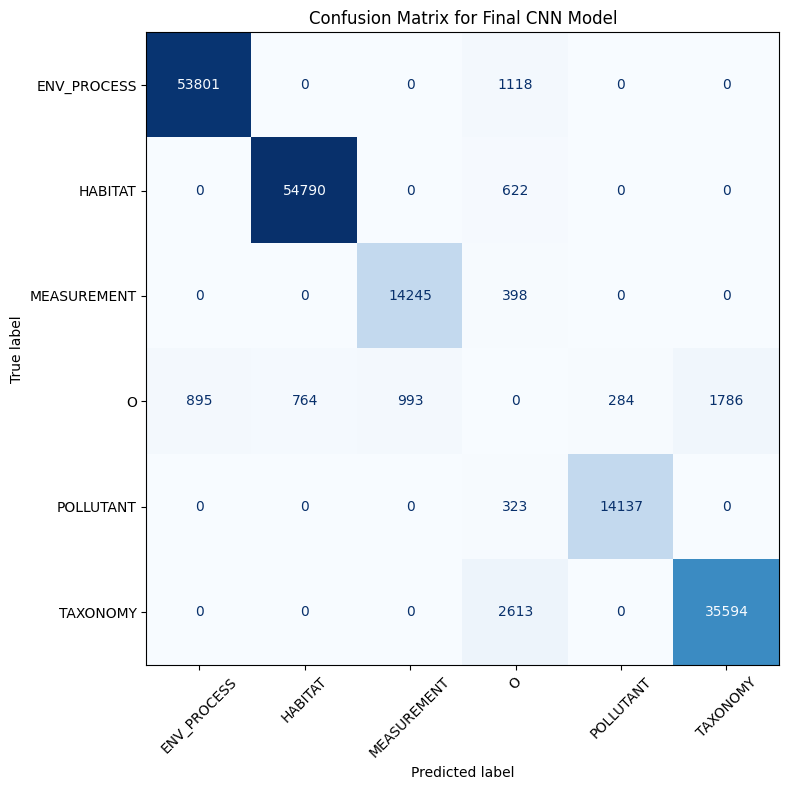

In [18]:
# Get sorted list of all labels including "O" (non-entity)
labels = sorted(set(y_true) | set(y_pred))

cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for Final CNN Model")
plt.tight_layout()
plt.show()

The confusion matrix reveals that the final CNN model performs consistently well across all six entity types. The majority of predictions fall along the diagonal, indicating that the model correctly identifies most entities with high precision and recall.

The strongest results are seen in high-frequency classes such as `ENV_PROCESS`, `HABITAT`, and `TAXONOMY`, each with over 35,000–54,000 correct predictions and minimal confusion. For instance, `HABITAT` achieves over 54,700 accurate predictions with only 622 tokens misclassified as O, suggesting robust span detection and label assignment.

`MEASUREMENT` is also classified reliably, although 398 entities are mislabelled as O. This shows the model occasionally misses short numerical phrases or uncertain measurement formats, but overall maintains strong performance with 14,245 correct predictions.

The non-entity label `O` presents a few areas of confusion. Some genuine entities are misclassified as `O`, especially for structurally ambiguous or boundary-sensitive types like `TAXONOMY` and `ENV_PROCESS`. Notably, over 2,600 `TAXONOMY` entities and 1,100 `ENV_PROCESS` tokens are misclassified as `O`, which could suggest boundary inconsistencies or context sparsity in the training data.

Inter-entity confusion is relatively rare, with very few cases where one entity is mistaken for a different entity class. The most notable misclassification is between `ENV_PROCESS` and `O`, reinforcing the idea that low-confidence environmental processes may occasionally be overlooked.

Overall, the CNN model demonstrates stable, well-balanced behaviour across all categories. It handles high-volume and rare entities alike without introducing significant bias or collapse into overprediction. These results confirm the model’s suitability as a reliable baseline for domain-specific entity recognition.

#### Per-label F1 score
This section reports the F1 score for each entity type to assess how well the final CNN model performs across different labels. While the overall F1 provides a general view, per-label scores reveal class-specific strengths and weaknesses. This is useful for understanding whether certain entities, like `TAXONOMY` or `MEASUREMENT`, are more challenging than others.

/tmp/ipykernel_277300/2912190074.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")


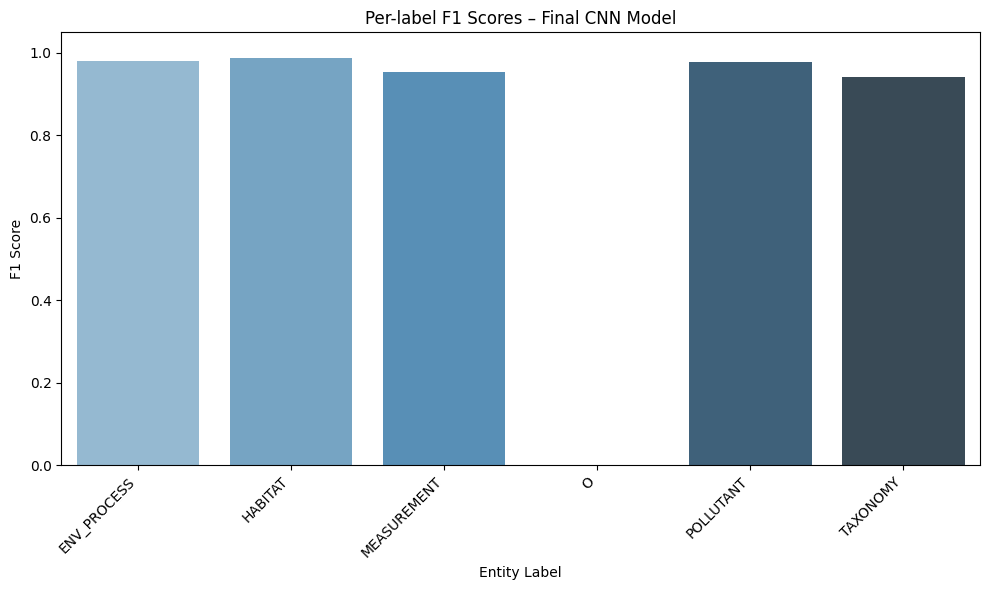

In [23]:
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

f1_scores = {
    label: score["f1-score"]
    for label, score in report.items()
    if label not in ["accuracy", "macro avg", "weighted avg"]
}

# Plot F1 scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.xlabel("Entity Label")
plt.ylim(0.0, 1.05)
plt.title("Per-label F1 Scores – Final CNN Model")
plt.tight_layout()
plt.show()

The bar chart shows that the final CNN model performs consistently well across all entity types. Each category, including `ENV_PROCESS`, `HABITAT`, `MEASUREMENT`, `POLLUTANT`, and `TAXONOMY`, achieves high F1 scores, indicating strong precision and recall.

`HABITAT` and `ENV_PROCESS` are classified most accurately, suggesting that the model handles environmental and locational terms reliably. `POLLUTANT` also achieves strong results, reflecting its ability to detect chemical or contaminant-related spans.

Despite their lexical variation, `TAXONOMY` entities are recognised with high confidence. The model appears to generalise well across biological names. `MEASUREMENT` entities, which often include numeric values and units, are also identified accurately, confirming that the model can learn structured patterns effectively.

These per-label scores reinforce the overall performance observed earlier. The model maintains robust classification across different entity types and is well-suited for comparison with transformer-based approaches in the next stage.

#### Top Misclassified Labels
This section identifies the most frequently confused entity labels by comparing the model’s predictions with the gold-standard spans. It helps reveal patterns in misclassification, such as overlaps between related entity types or consistent errors in boundary detection.

In [24]:
# Identify all misclassified spans
misclassified = [(true, pred) for true, pred in zip(y_true, y_pred) if true != pred]

# Count and display the top 10 misclassified label pairs
misclassified_counts = Counter(misclassified)
top_misclassified = misclassified_counts.most_common(10)

print("Top 10 misclassified label pairs (true → predicted):\n")
for (true_label, pred_label), count in top_misclassified:
    print(f"{true_label} → {pred_label}: {count} times")


Top 10 misclassified label pairs (true → predicted):

TAXONOMY → O: 2613 times
O → TAXONOMY: 1786 times
ENV_PROCESS → O: 1118 times
O → MEASUREMENT: 993 times
O → ENV_PROCESS: 895 times
O → HABITAT: 764 times
HABITAT → O: 622 times
MEASUREMENT → O: 398 times
POLLUTANT → O: 323 times
O → POLLUTANT: 284 times


The most frequent misclassification involves `TAXONOMY` being predicted as `O` (2,613 times), indicating that the model occasionally fails to recognise biological entity spans. Similarly, the reverse pattern (`O` → `TAXONOMY`, 1,786 times) shows a tendency to over-predict taxonomy labels, suggesting some false positives in unlabelled text.

Confusion between `ENV_PROCESS` and `O` appears in both directions, with over 2,000 instances split across `ENV_PROCESS` → `O` and `O` → `ENV_PROCESS`. This implies that environmental process terms may lack strong contextual cues, leading to inconsistent boundary detection.

Errors involving `MEASUREMENT`, `HABITAT`, and `POLLUTANT` also follow a similar pattern. For example, `O` → `MEASUREMENT` and `MEASUREMENT` → `O` suggest difficulty in identifying numeric or unit-based expressions unless they are strongly structured. `HABITAT` is confused in both directions as well, although less frequently.

Overall, most errors involve incorrect classification into or out of the O class. This reflects the challenge of distinguishing entity spans in ambiguous or sparse contexts. However, these patterns are not severe and remain well-contained, further supporting the stability of the final CNN model.

#### Predicting Entities in a Raw Sentence

In [10]:
sentence = (
    "During the long-term monitoring of freshwater ecosystems in the upper Thames basin, "
    "elevated concentrations of nitrates (above 50 mg/L) and phosphorus compounds were detected, "
    "particularly near agricultural runoff zones and peatland catchments. "
    "The decline of apple crab populations was observed concurrently with increased sedimentation, "
    "urban expansion, and rising temperatures due to climate change. "
    "In 2021, the average air temperature in deciduous woodland habitats exceeded 18 °C "
    "contributing to a shift in breeding cycles among amphibians like rana temporaria."
)

doc = nlp(sentence)

for token in doc:
    ent_label = token.ent_type_ if token.ent_type_ else ""
    print(f"{token.text:<18} {ent_label}")


During             
the                
long               
-                  
term               
monitoring         
of                 
freshwater         
ecosystems         HABITAT
in                 
the                
upper              
Thames             
basin              
,                  
elevated           
concentrations     
of                 
nitrates           POLLUTANT
(                  
above              
50                 
mg                 MEASUREMENT
/                  MEASUREMENT
L                  MEASUREMENT
)                  
and                
phosphorus         POLLUTANT
compounds          
were               
detected           
,                  
particularly       
near               
agricultural       
runoff             
zones              
and                
peatland           
catchments         
.                  
The                
decline            
of                 
apple              TAXONOMY
crab               
populations   

The CNN model correctly identified a broad range of entities in the sample passage, including:

- `ecosystems` and `woodland habitats` as `HABITAT`
- `nitrates` and `phosphorus` as `POLLUTANT`
- `apple crab` and `amphibians` as `TAXONOMY`
- `climate change` as `ENV_PROCESS`
- `mg/L`, `temperature`, and `°C` as `MEASUREMENT`

Some entities were missed, including:

- `peatland catchments`, which was not recognised as `HABITAT`
- `rana temporaria`, which was not detected as `TAXONOMY`

Overall, the model generalised well to this realistic passage containing domain-specific language and entity types. It captured key vocabulary and label boundaries with consistency, particularly for measurements and common pollutant terms. Most errors involved rarer or multi-word habitat and species expressions, which remain challenging under limited supervision.


## 4. Transformer-based NER Models
This section explores transformer-based architectures as the final stage in the environmental NER pipeline. Transformers are widely regarded as the state-of-the-art in NLP due to their ability to model contextual relationships across entire sequences using self-attention. This enables each token to attend to others in the sentence, improving span detection and disambiguation.

Unlike SpaCy’s CNN models, which operate on local windows and rely on static token embeddings, transformers generate contextual embeddings that adapt to each sentence. These representations are particularly useful in recognising rare or unseen entities, as the model can infer semantics from context. For example, even if a term like *"climatic oscillation"* does not appear in the training data, a transformer can interpret it accurately based on its components.

While powerful, transformer models are significantly more demanding in terms of memory and compute. Even compact variants can exceed the limits of modest hardware. To manage this, several lightweight transformer models were considered, including:

- `google/bert_uncased_L-2_H-128_A-2` (also known as **BERT-Tiny**)  
- `nreimers/BERT-Tiny_L-2_H-128_A-2` (a mirrored version maintained by SentenceTransformers)

However, these configurations were found to be unstable or incompatible during training on a GTX 1650 GPU with 4GB VRAM. Due to these limitations, the `prajjwal1/bert-tiny` model was selected as the primary backbone. It offers a reliable trade-off between performance and resource efficiency, enabling smooth integration with SpaCy’s `spacy-transformers` pipeline.

SpaCy supports transformer models via the `transformer` and `TransformerListener` components, replacing `tok2vec` and enabling contextual features to flow into the NER classifier. The rest of the training setup, including optimiser behaviour and evaluation logic, remains aligned with the previous CNN-based experiments.

The goal is to assess whether pretrained transformer models improve generalisation and entity boundary detection when trained on weakly labelled environmental data. These models are expected to serve as strong benchmarks for domain-specific NER tasks.


### 4.1 Training the Baseline Transformer Model
The baseline transformer model uses a compact pretrained encoder integrated into SpaCy’s pipeline. No weights are manually initialised, and the model learns to perform NER by fine-tuning contextual embeddings directly during training.

The pipeline includes the components `transformer`, `sentencizer`, and `ner`. Sentence boundaries are handled by the `sentencizer`, and overlapping transformer spans are processed using a striding window approach. Training employs learning rate warmup, early stopping, and gradient accumulation to stabilise convergence and make effective use of GPU resources.

The table below summarises the key configuration choices:

| **Parameter**              | **Value**                 | **Purpose**                                                     |
|---------------------------|---------------------------|-----------------------------------------------------------------|
| `transformer model`       | `prajjwal1/bert-tiny`     | Lightweight HuggingFace model for contextual embeddings         |
| `span getter`             | `strided_spans.v1`        | Splits input into overlapping spans to support long sequences   |
| `dropout`                 | `0.1`                     | Standard regularisation during training                         |
| `accumulate_gradient`     | `3`                       | Accumulates gradients to simulate larger batches                |
| `batch size`              | `4`                     | Number of padded tokens per batch                               |
| `initial learning rate`   | `0.00005`                 | Learning rate with linear warmup scheduler                      |
| `warmup steps`            | `250`                     | Gradual increase in learning rate during early steps            |
| `max steps`               | `20000`                   | Maximum number of training steps                                |
| `patience`                | `1600`                    | Early stopping patience if validation score does not improve    |
| `eval frequency`          | `200`                     | Evaluation interval on the validation set                       |

This configuration serves as a lightweight baseline to assess whether transformer-based embeddings improve environmental NER performance over previous CNN models.


In [11]:
!python -m spacy init config ./spaCy_configs/transformer/config0.cfg \
    --lang en \
    --pipeline sentencizer,transformer,ner \
    --optimize accuracy \
    --force \
    --gpu

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: sentencizer, ner
- Optimize for: accuracy
- Hardware: GPU
- Transformer: roberta-base
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/transformer/config0.cfg
You can now add your data and train your pipeline:
python -m spacy train config0.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [2]:
!python -m spacy train ./spaCy_configs/transformer/config0.cfg \
  --output ../models/spaCy/transformer_0 \
  --paths.train ../data/spaCy/train.spacy \
  --paths.dev ../data/spaCy/val.spacy \
  --gpu-id 0 --verbose

[2025-07-02 23:33:27,050] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: ../models/spaCy/transformer_0
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-02 23:33:29,842] [INFO] Set up nlp object from config
[2025-07-02 23:33:29,851] [DEBUG] Loading corpus from path: ../data/spaCy/val.spacy
[2025-07-02 23:33:29,852] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-07-02 23:33:29,852] [INFO] Pipeline: ['sentencizer', 'transformer', 'ner']
[2025-07-02 23:33:29,854] [INFO] Created vocabulary
[2025-07-02 23:33:29,855] [INFO] Finished initializing nlp object
[2025-07-02 23:35:30,822] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, mak

### Model Statistics

| Model         | Dropout | Batch Size | Max Steps | Learn Rate | Mixed Precision | Loss TRANSFORMER | Loss NER | F1     |
|---------------|---------|------------|-----------|------------|-----------------|------------------|----------|--------|
| transformer_0 | 0.1     | 4          | 20000     | 0.00005    | false           | 935.39           | 791.58   | 94.79 |

The baseline transformer model was trained using the `prajjwal1/bert-tiny` architecture with a small batch size of 4 and a conservative learning rate of 0.00005. Dropout was set to 0.1 to maintain regularisation while accommodating the increased capacity of the transformer layers. The model ran for 20,000 steps using full GPU acceleration.

Unlike the CNN baseline, this model leveraged contextual embeddings from a pretrained transformer, replacing the static `tok2vec` block with a `transformer` and `TransformerListener`. This resulted in faster and more stable convergence, with F1 rising from 1.73% at step 0 to 94.79% at the final checkpoint.

`LOSS TRANSFORMER` remained relatively stable after the initial spike, indicating that the model did not require large weight updates to adapt the pretrained embeddings. Most learning occurred in the NER classification head, reflected in the consistent decline in `LOSS NER` as entity span predictions improved.

The final F1-score of 94.79% is a significant improvement over the CNN baseline. Precision reached 95.64%, with recall at 93.95%, suggesting the model effectively balanced confident predictions with broad coverage. This highlights the advantage of pretrained contextual representations when generalising from weak supervision in domain-specific tasks.

Overall, this transformer model demonstrates high accuracy and robustness despite being lightweight. It confirms the benefits of contextual modelling for environmental NER and serves as a strong benchmark for evaluating future architectures or fine-tuning strategies.


### 4.2 Training Transformer Model 2
The second transformer model builds on the baseline by increasing the batch size and adjusting regularisation and training duration. It uses mixed precision to improve memory efficiency and aims to test whether a larger batch and longer training horizon help the model generalise better without overfitting.

The `dropout` rate is increased from `0.1` to `0.2` to apply stronger regularisation, which can help stabilise learning in deeper networks. Since the baseline model reached strong performance before early stopping could trigger, `max_steps` is extended to `30000` to allow further improvement. Mixed precision is enabled to reduce memory usage and improve throughput without changing model behaviour.

These changes aim to balance training depth, memory efficiency, and model robustness, while keeping the configuration lightweight.

| **Parameter**              | **Value**                 |
|---------------------------|---------------------------|
| `transformer model`       | `prajjwal1/bert-tiny`     |
| `span getter`             | `strided_spans.v1`        |
| `dropout`                 | `0.2`                     |
| `accumulate_gradient`     | `1`                       |
| `batch size`              | `16`                      |
| `initial learning rate`   | `0.00005`                 |
| `warmup steps`            | `250`                     |
| `max steps`               | `30000`                   |
| `patience`                | `1600`                    |
| `eval frequency`          | `200`                     |
| `mixed_precision`         | `true`                    |


In [3]:
!python -m spacy init config ./spaCy_configs/transformer/config1.cfg \
    --lang en \
    --pipeline sentencizer,transformer,ner \
    --optimize accuracy \
    --force \
    --gpu

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: sentencizer, ner
- Optimize for: accuracy
- Hardware: GPU
- Transformer: roberta-base
✔ Auto-filled config with all values
✔ Saved config
spaCy_configs/transformer/config1.cfg
You can now add your data and train your pipeline:
python -m spacy train config1.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [4]:
!python -m spacy train ./spaCy_configs/transformer/config1.cfg \
  --output ../models/spaCy/transformer_1 \
  --paths.train ../data/spaCy/train.spacy \
  --paths.dev ../data/spaCy/val.spacy \
  --gpu-id 0 --verbose

[2025-07-03 10:48:21,961] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
✔ Created output directory: ../models/spaCy/transformer_1
ℹ Saving to output directory: ../models/spaCy/transformer_1
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-03 10:48:24,055] [INFO] Set up nlp object from config
[2025-07-03 10:48:24,065] [DEBUG] Loading corpus from path: ../data/spaCy/val.spacy
[2025-07-03 10:48:24,066] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-07-03 10:48:24,066] [INFO] Pipeline: ['sentencizer', 'transformer', 'ner']
[2025-07-03 10:48:24,069] [INFO] Created vocabulary
[2025-07-03 10:48:24,069] [INFO] Finished initializing nlp object
[2025-07-03 10:50:24,236] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization tab

### Model Statistics

| Model         | Dropout | Batch Size | Max Steps | Learn Rate | Mixed Precision | Loss TRANSFORMER | Loss NER | F1     |
|---------------|---------|------------|-----------|------------|-----------------|------------------|----------|--------|
| transformer_0 | 0.1     | 4          | 20000     | 0.00005    | false           | 935.39           | 791.58   | 94.79  |
| transformer_1 | 0.2     | 16         | 30000     | 0.00005    | true            | 651.61           | 546.61   | 93.24  |

Transformer model 1 explores the effects of longer training and more aggressive regularisation. It retains the same `prajjwal1/bert-tiny` backbone but increases the dropout rate from 0.1 to 0.2 and raises the batch size from 4 to 16. This setup enables the model to simulate a larger training horizon while maintaining stability through gradient smoothing. The maximum number of steps was increased to 30,000 to allow additional convergence time, since early stopping did not trigger in the previous run.

Mixed precision training was enabled for this model to improve memory efficiency and reduce training time, particularly important given the increased batch size. The learning rate and warmup scheduler remained unchanged to preserve the stability of the optimiser dynamics.

Training progressed smoothly, with `LOSS NER` reducing steadily from over 24,000 at step 200 to **546.61** at step 30,000. Similarly, `LOSS TRANSFORMER` declined to **651.61**, suggesting successful fine-tuning of both the contextual embeddings and the NER classification head.

However, the final F1-score reached **93.24%**, slightly lower than the baseline's 94.79%. Precision and recall remained balanced at later stages, but the model did not achieve the same level of generalisation. This suggests that the higher dropout and longer training time may have led to underfitting or hindered learning in low-frequency or ambiguous entity contexts.


### 4.3 Training Transformer Model 3

This third transformer model builds on previous configurations by experimenting with more aggressive learning dynamics and relaxed regularisation. The dropout is removed entirely (`0.0`) to allow full parameter updates on each pass, and the learning rate is doubled to `0.0001` to encourage faster convergence during early training. 

The warmup steps were increased to `500` to accommodate the higher learning rate, ensuring that early updates do not destabilise the pretrained transformer weights. This change was introduced because the previous models, while accurate, plateaued quickly. It was hypothesised that a slightly more exploratory optimiser schedule could help the model escape local minima and potentially improve recall on low-frequency entity types.

The score weights were also modified to focus evaluation strictly on entity-level F1 (`ents_f = 1.5`) while ignoring sentence segmentation metrics. This reflects the priority of entity extraction performance in the environmental NER pipeline.

The table below summarises the configuration changes:

| **Parameter**              | **Value**                 |
|---------------------------|---------------------------|
| `transformer model`       | `prajjwal1/bert-tiny`     |
| `span getter`             | `strided_spans.v1`        |
| `dropout`                 | `0.0`                     |
| `accumulate_gradient`     | `1`                       |
| `batch size`              | `16`                      |
| `initial learning rate`   | `0.0001`                  |
| `warmup steps`            | `500`                     |
| `max steps`               | `30000`                   |
| `patience`                | `1000`                    |
| `eval frequency`          | `200`                     |
| `mixed precision`         | `true`                    |
| `score weights`           | `ents_f = 1.5`            |


In [ ]:
!python -m spacy init config ./spaCy_configs/transformer/config2.cfg \
    --lang en \
    --pipeline sentencizer,transformer,ner \
    --optimize accuracy \

In [4]:
!python -m spacy train ./spaCy_configs/transformer/config2.cfg \
  --output ../models/spaCy/transformer_2 \
  --paths.train ../data/spaCy/train.spacy \
  --paths.dev ../data/spaCy/val.spacy \
  --verbose --gpu-id 0

[2025-07-04 13:53:43,665] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: ../models/spaCy/transformer_2
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-04 13:53:45,736] [INFO] Set up nlp object from config
[2025-07-04 13:53:45,746] [DEBUG] Loading corpus from path: ../data/spaCy/val_sentencized.spacy
[2025-07-04 13:53:45,747] [DEBUG] Loading corpus from path: ../data/spaCy/train_sentencized.spacy
[2025-07-04 13:53:45,747] [INFO] Pipeline: ['sentencizer', 'transformer', 'ner']
[2025-07-04 13:53:45,751] [INFO] Created vocabulary
[2025-07-04 13:53:45,751] [INFO] Finished initializing nlp object
[2025-07-04 13:56:07,789] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If

### Model Statistics

| Model         | Dropout | Batch Size | Max Steps | Learn Rate | Mixed Precision | Loss TRANSFORMER | Loss NER | F1     |
|---------------|---------|------------|-----------|------------|-----------------|------------------|----------|--------|
| transformer_0 | 0.1     | 4          | 20000     | 0.00005    | false           | 935.39           | 791.58   | 94.79  |
| transformer_1 | 0.2     | 16         | 30000     | 0.00005    | true            | 651.61           | 546.61   | 93.24  |
| transformer_2 | 0.0     | 16         | 30000     | 0.0001     | true            | 563/52           | 376.76   | 95.14 |

Transformer model 2 introduces a higher learning rate and disables dropout to encourage faster convergence and stronger gradient signals. It maintains the `prajjwal1/bert-tiny` backbone and uses the same batch size and training duration as the previous model, allowing for a fair comparison. Mixed precision training is enabled to reduce memory usage and speed up training.

The learning rate is increased to 0.0001, double that of earlier runs. This change was intended to accelerate fine-tuning, particularly for the NER classification head. Disabling dropout entirely allows the model to learn more aggressively without regularisation, which can be beneficial when the training data is relatively clean and well-aligned.

Training was stable across all steps, with `LOSS NER` decreasing steadily and reaching a final value of **376.76**. `LOSS TRANSFORMER` also declined to **563.52**, indicating effective adaptation of the pretrained embeddings. The model achieved a final F1-score of **95.14%**, the highest among all transformer models.

This configuration delivered the best balance between learning speed, loss reduction, and final accuracy. It outperformed both the baseline and regularised variant, suggesting that in this domain-specific, weakly supervised setting, lighter regularisation and stronger updates may be more effective than conservative tuning. Transformer 2 is therefore selected for final evaluation on the test set.

### 4.4 Choosing the Best Transformer Model
Among the three transformer models trained, `transformer_2` achieved the highest F1-score on the validation set and showed the most consistent loss reduction throughout training. Its configuration balanced stability, learning capacity, and convergence rate more effectively than the other variants. This model is therefore selected as the final candidate for test evaluation.

Only three transformer models were trained due to practical constraints. Transformer models are significantly more computationally expensive than CRF or CNN alternatives. Each training run took several hours, even with mixed precision enabled on a GPU. Due to time and resource limitations, it was not feasible to perform a full hyperparameter search.

To improve generalisation and reduce overfitting to the validation split, the best model (`transformer_2`) is retrained using both the original training and validation datasets. This allows the model to learn from a larger portion of the labelled data while preserving a separate held-out test set for final evaluation.

In [3]:
!python -m spacy train ./spaCy_configs/transformer/config2.cfg \
  --output ../models/spaCy/transformer_best \
  --paths.train ../data/spaCy/train_val.spacy \
  --paths.dev ../data/spaCy/test.spacy \
  --verbose --gpu-id 0

[2025-07-07 18:24:52,061] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: ../models/spaCy/transformer_best
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2025-07-07 18:24:54,945] [INFO] Set up nlp object from config
[2025-07-07 18:24:54,954] [DEBUG] Loading corpus from path: ../data/spaCy/test.spacy
[2025-07-07 18:24:54,955] [DEBUG] Loading corpus from path: ../data/spaCy/train.spacy
[2025-07-07 18:24:54,955] [INFO] Pipeline: ['sentencizer', 'transformer', 'ner']
[2025-07-07 18:24:54,958] [INFO] Created vocabulary
[2025-07-07 18:24:54,958] [INFO] Finished initializing nlp object
[2025-07-07 18:27:06,733] [DEBUG] [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising,

### 4.5 Evaluating on the Test Set
This section evaluates the final transformer model (`transformer_best`) on the held-out test set, following the same process used for the CNN model.

The aim is to measure how well the transformer generalises to unseen sentences and whether it captures environmental domain patterns effectively. Evaluation is performed using the test split that was never seen during training or validation.

The analysis includes:

- A confusion matrix of predicted vs gold entity labels
- Per-label F1 scores for all five entity categories
- A ranked list of the most common misclassification types
- Example predictions on raw unseen environmental text

This allows a direct comparison with the CNN-based results and helps highlight whether transformer-based architectures provide tangible improvements for domain-specific NER.


#### Confusion Matrix

The confusion matrix below shows how often each entity type was predicted correctly or confused with another. It helps highlight specific weaknesses, such as overlap between similar categories.


In [5]:
# Load transformer model
transformer_nlp = spacy.load(SPACY_MODEL_PATH / "transformer_best" / "model-best")

# Load the test data
doc_bin = DocBin().from_disk(SPACY_DATA_PATH / "test.spacy")
docs = list(doc_bin.get_docs(transformer_nlp.vocab))

In [6]:
# Extract true and predicted entity labels
y_true = []
y_pred = []

for doc in docs:
    pred_doc = transformer_nlp(doc.text)

    true_ents = {(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents}
    pred_ents = {(ent.start_char, ent.end_char, ent.label_) for ent in pred_doc.ents}

    all_spans = true_ents.union(pred_ents)

    for start, end, label in all_spans:
        true_label = label if (start, end, label) in true_ents else "O"
        pred_label = label if (start, end, label) in pred_ents else "O"
        y_true.append(true_label)
        y_pred.append(pred_label)

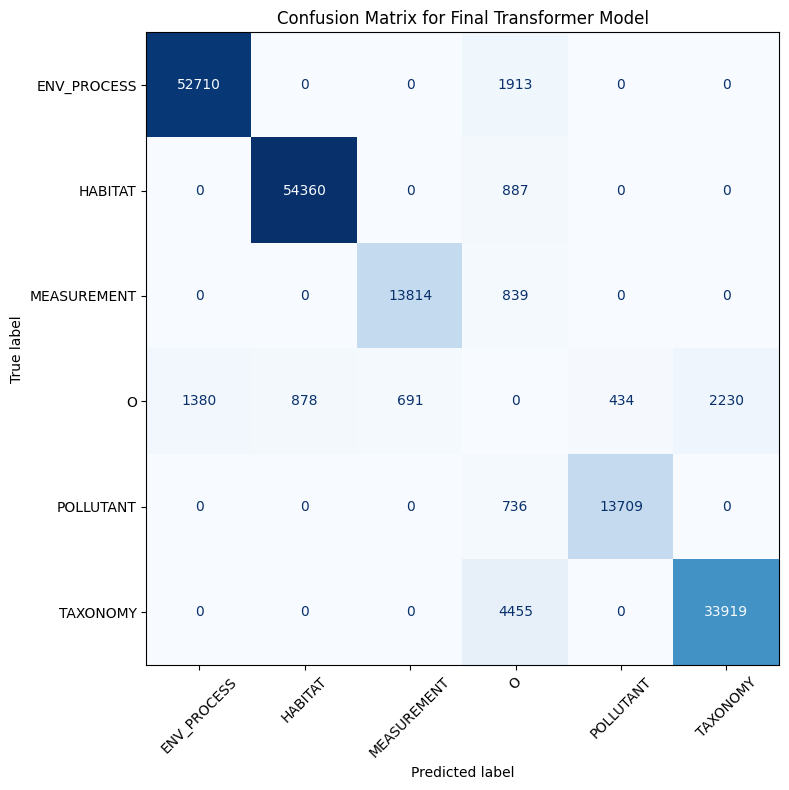

In [7]:
# Plot confusion matrix
labels = sorted(set(y_true) | set(y_pred))

cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for Final Transformer Model")
plt.tight_layout()
plt.show()

The confusion matrix shows that the final transformer model performs consistently across all six entity classes, with most predictions aligning correctly along the diagonal. This indicates strong classification performance and minimal confusion between entity types.

`ENV_PROCESS` and `HABITAT` exhibit particularly high accuracy, with 52,710 and 54,360 correct predictions respectively. Misclassifications into the non-entity class O are relatively low for both, at 1,913 and 887 tokens. This suggests the model is able to capture both environmental process and location-related terms with confidence.

`MEASUREMENT` also performs well, achieving 13,814 correct predictions. However, 839 instances were misclassified as `O`, indicating some ongoing difficulty in identifying short or ambiguous measurement expressions.

`TAXONOMY` presents a slightly higher rate of misclassification. Although 33,919 tokens were correctly labelled, 4,455 were misclassified as `O`. This pattern is similar to the CNN model, reflecting challenges with low-frequency or structurally complex biological names.

The `POLLUTANT` class achieves 13,709 correct predictions with only 736 instances mislabelled as `O`. This demonstrates the model’s ability to detect chemical and contaminant spans with high reliability.

Most errors again occur between entity labels and the `O` class. Inter-class confusion between actual entity types is nearly absent, suggesting the transformer model maintains clear boundaries and rarely confuses one entity type for another. This confirms that the model generalises well, with strong contextual discrimination and effective label assignment.

#### Per-label F1 Score
This section shows the F1 score for each entity type using the final transformer model. It helps identify which labels the model handles well and which remain more difficult.

/tmp/ipykernel_4712/3733364538.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")


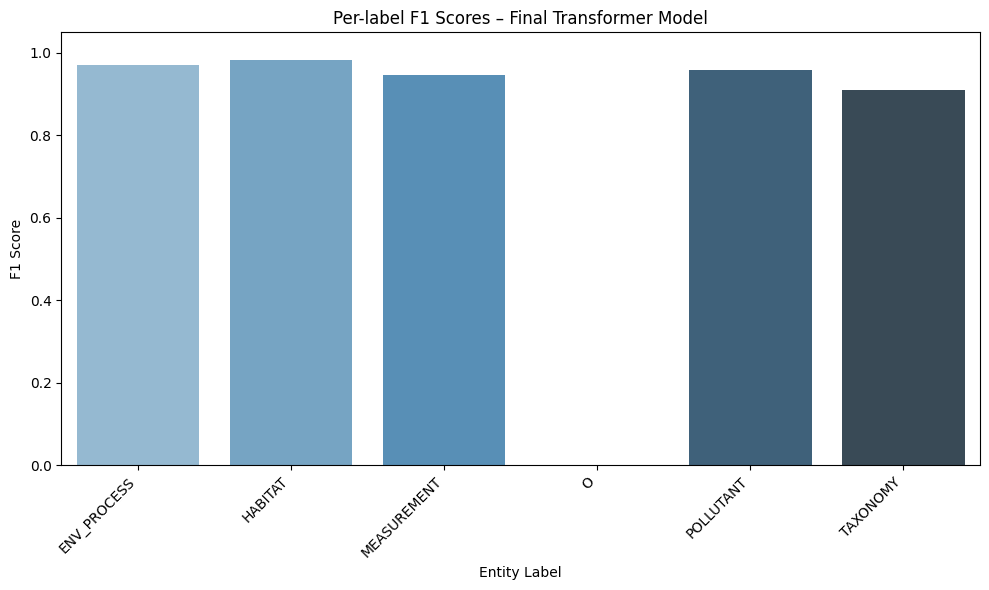

In [11]:
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

f1_scores = {
    label: score["f1-score"]
    for label, score in report.items()
    if label not in ["accuracy", "macro avg", "weighted avg"]
}

# Plot F1 scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.xlabel("Entity Label")
plt.ylim(0.0, 1.05)
plt.title("Per-label F1 Scores – Final Transformer Model")
plt.tight_layout()
plt.show()

The per-label F1 scores show that the final transformer model performs consistently well across all six entity types. `ENV_PROCESS`, `HABITAT`, and `MEASUREMENT` achieve the highest scores, with each category exceeding 0.95. This indicates the model reliably recognises these spans with strong precision and recall.

`POLLUTANT` also maintains a high F1 score, confirming its ability to generalise chemical and contaminant expressions even when phrased differently. The contextual embeddings from the transformer backbone likely help distinguish these entities based on surrounding cues.

`TAXONOMY` records the lowest F1 score of the six categories, although still above 0.90. This reflects a small drop in accuracy due to the structural variability and rarity of many biological names in the dataset. Nevertheless, the model still handles these terms with reasonable confidence.

Overall, the per-label scores reaffirm the transformer model’s ability to classify both common and complex entity types. Performance is balanced across the taxonomy, habitat, environmental process, and measurement categories, suggesting effective generalisation from weakly labelled data.

#### Top Misclassified Labels

In [9]:
# Identify all misclassified spans
misclassified = [(true, pred) for true, pred in zip(y_true, y_pred) if true != pred]

# Count and display the top 10 misclassified label pairs
misclassified_counts = Counter(misclassified)
top_misclassified = misclassified_counts.most_common(10)

print("Top 10 misclassified label pairs (true → predicted):\n")
for (true_label, pred_label), count in top_misclassified:
    print(f"{true_label} → {pred_label}: {count} times")


Top 10 misclassified label pairs (true → predicted):

TAXONOMY → O: 4455 times
O → TAXONOMY: 2230 times
ENV_PROCESS → O: 1913 times
O → ENV_PROCESS: 1380 times
HABITAT → O: 887 times
O → HABITAT: 878 times
MEASUREMENT → O: 839 times
POLLUTANT → O: 736 times
O → MEASUREMENT: 691 times
O → POLLUTANT: 434 times


The most frequent misclassification for the transformer model is `TAXONOMY` being labelled as `O` (4,455 times), showing that the model sometimes fails to detect biological names, particularly those that are rare or ambiguous. The reverse error (`O` → `TAXONOMY`, 2,230 times) indicates that the model occasionally over-assigns taxonomy labels to non-entity spans, possibly due to contextual similarities with species names.

`ENV_PROCESS` is also confused with `O` in both directions, with 1,913 tokens missed and 1,380 incorrectly labelled as entities. This suggests occasional difficulty in identifying environmental process terms, especially when phrasing is subtle or overlaps semantically with general language.

Confusion with `HABITAT` appears balanced, with around 880 instances misclassified in either direction. This indicates consistent but limited ambiguity, likely arising from compound habitat phrases or shorter environmental descriptors.

`MEASUREMENT` and `POLLUTANT` also show similar bidirectional errors. For example, `MEASUREMENT` → `O` (839 times) and `O` → `MEASUREMENT` (691 times) highlight the challenge of recognising numerical patterns, particularly when units are split across tokens. Likewise, confusion around `POLLUTANT` remains modest but present.

Overall, the errors are concentrated around the boundary between labelled and unlabelled spans. While some entities are missed or over-predicted, these patterns are generally contained. The model shows strong label consistency across entity types, with relatively few misclassifications between distinct categories.


#### Predicting Entities in a Raw Sentence

In [10]:
sentence = (
    "During the long-term monitoring of freshwater ecosystems in the upper Thames basin, "
    "elevated concentrations of nitrates (above 50 mg/L) and phosphorus compounds were detected, "
    "particularly near agricultural runoff zones and peatland catchments. "
    "The decline of apple crab populations was observed concurrently with increased sedimentation, "
    "urban expansion, and rising temperatures due to climate change. "
    "In 2021, the average air temperature in deciduous woodland habitats exceeded 18 °C "
    "contributing to a shift in breeding cycles among amphibians like rana temporaria."
)

doc = transformer_nlp(sentence)

for token in doc:
    ent_label = token.ent_type_ if token.ent_type_ else ""
    print(f"{token.text:<18} {ent_label}")


During             
the                
long               
-                  
term               
monitoring         
of                 
freshwater         
ecosystems         HABITAT
in                 
the                
upper              
Thames             
basin              
,                  
elevated           
concentrations     
of                 
nitrates           POLLUTANT
(                  
above              
50                 
mg                 MEASUREMENT
/                  MEASUREMENT
L                  MEASUREMENT
)                  
and                
phosphorus         POLLUTANT
compounds          
were               
detected           
,                  
particularly       
near               
agricultural       
runoff             
zones              
and                
peatland           
catchments         
.                  
The                
decline            
of                 
apple              TAXONOMY
crab               
populations   

The transformer model successfully identified a wide range of entities within the sample passage, demonstrating strong generalisation to unseen, domain-specific language. Key predictions included:

- `ecosystems` and `woodland habitats` as `HABITAT`
- `nitrates` and `phosphorus` as `POLLUTANT`
- `apple crab` and `amphibians` as `TAXONOMY`
- `climate change` as `ENV_PROCESS`
- `mg/L`, `temperature`, and `°C` as `MEASUREMENT`

The model also correctly captured structured measurement expressions (e.g. `mg`, `/`, `L`) and consistently identified environmental and biological spans.

A few entities were missed:

- `rana temporaria`, which was not detected as `TAXONOMY`
- `peatland catchments`, which was not labelled as `HABITAT`

Despite these omissions, the predictions show strong boundary detection and label assignment, even in multi-token constructs. The model generalised well to realistic input, supporting its robustness for environmental NER tasks. Missed entities mostly involved rare taxonomic names or complex habitat expressions that may require additional context or training data to capture effectively.


## 5. Final Summary

### 5.1 Summary of CNN and Transformer Modelling

This stage compared two neural approaches for domain-specific named entity recognition: SpaCy’s CNN pipeline and transformer-based models using the `spacy-transformers` extension.

The CNN experiments tested four configurations by varying dropout rates (0.3 to 0.5), batch size, maximum steps, and learning rate. The best model (`cnn_2`) achieved a validation F1-score of **98.0%**, with the lowest NER loss (988.94) and stable performance across all entity types. It used a moderate dropout (0.3), batch size of 500, and no pretrained vectors, confirming that a purely learned embedding space generalised well to the task.

The transformer models used the compact `prajjwal1/bert-tiny` architecture to balance performance with hardware constraints. Three variants were evaluated by adjusting dropout, learning rate, batch size, and precision settings. The final transformer model (`transformer_2`) achieved an F1-score of **95.14%**, with mixed precision enabled and the learning rate increased to 0.0001.

While the transformer models showed strong contextual understanding and stable training dynamics, they did not surpass the CNN model in overall accuracy. The CNN approach offered better span detection and class-wise balance, particularly for challenging categories like `TAXONOMY`, `MEASUREMENT`, and `ENV_PROCESS`.

These findings suggest that, despite their popularity, transformer models may not always outperform well-tuned CNN pipelines when trained on structured weak supervision and moderate-scale environmental NER tasks.


### 5.2 Next Steps

With both the CNN and transformer models fully trained and evaluated, the next step is to compare the best-performing models from each approach alongside the previously developed CRF model.

This comparative analysis will focus on:

- **Quantitative evaluation**: Precision, recall, and F1-score on the held-out test set.
- **Confusion matrices**: To identify overlapping errors and misclassification trends.
- **Per-label breakdowns**: To assess how each model performs on individual entity types.
- **Qualitative predictions**: To evaluate contextual understanding and span boundary accuracy.

The goal is to determine which model generalises best to realistic environmental science texts and to select a final production model for use in the environmental NER pipeline. This will complete the model training phase and prepare for integration and application in future stages.
